In [48]:
# import libraries 
import cv2
import numpy as np
import matplotlib.pyplot as plt 

In [49]:
# load video as a list of frames 
video = cv2.VideoCapture('videos/samplevideo1.mp4')
frames = []
valid, frame = video.read()
while valid: 
    frames.append(frame)
    valid, frame = video.read()
    
# print number of frames in video
print('Video consists of {} frames'.format(len(frames)))

Video consists of 204 frames


Detected edges in frame


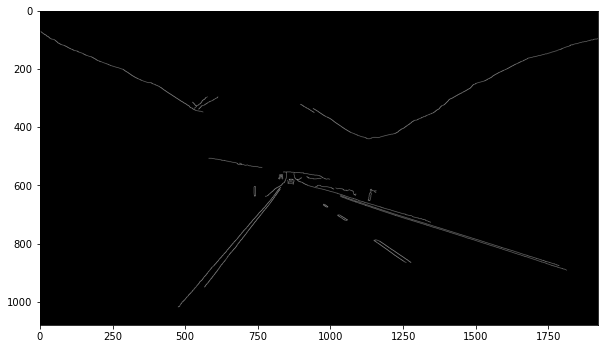

In [50]:
# detect edges in a frame
def detect_edges(frame):
    grayscale_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    reduced_blur_frame = cv2.GaussianBlur(grayscale_frame, (5, 5), 0)
    detected_edges_frame = cv2.Canny(reduced_blur_frame, 50, 150)
    return detected_edges_frame

# show detected edges in a frame
print('Detected edges in frame')
processed_frame = detect_edges(frames[0])
plt.figure(figsize=(10, 10))
plt.imshow(processed_frame, cmap="gray")

Masked frame
(1080, 1920)


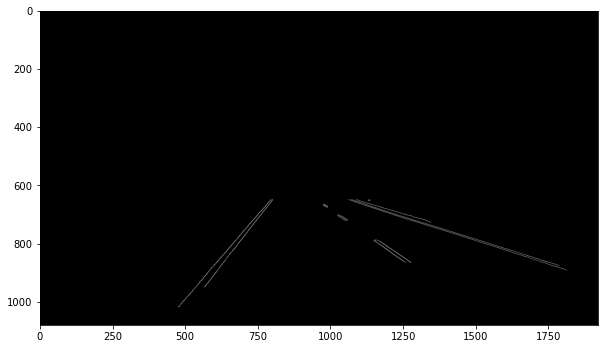

In [61]:
# mask the image based on region of interest 
def mask_region_of_interest(frame):
    frame_height = frame.shape[0]
    frame_width = frame.shape[1]
    polygons = np.array([ 
        [(0, frame_height), (frame_width, frame_height), (frame_width, frame_height // 5 * 3), (0, frame_height // 5 * 3)] 
    ])
    mask = np.zeros_like(frame) 
    cv2.fillPoly(mask, polygons, 255)
    masked_frame = cv2.bitwise_and(frame, mask)
    return masked_frame

# show masked frame
print('Masked frame')
processed_frame = mask_region_of_interest(processed_frame)
plt.figure(figsize=(10, 10))
plt.imshow(processed_frame, cmap="gray")

In [128]:
# create lane marker points
def create_lane_marker_points(frame, params):
    slope, intercept = params[0], params[1]
    y1 = frame.shape[0]
    y2 = int(y1 * 3 / 5)
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    return np.array([x1, y1, x2, y2])

In [129]:
# find lane lines
def find_lane_lines(frame, lines):
    left_lane_fit, right_lane_fit = [], []
    if lines is None: 
        return None
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope, intercept = parameters[0], parameters[1]
        if slope < 0: 
            left_lane_fit.append((slope, intercept))
        else: 
            right_lane_fit.append((slope, intercept))
    left_lane_avgfit = np.average(left_lane_fit, axis=0)
    if np.any(np.isnan(left_lane_avgfit)): 
        return None
    left_lane_line = create_lane_marker_points(frame, left_lane_avgfit)
    right_lane_avgfit = np.average(right_lane_fit, axis=0)
    if np.any(np.isnan(right_lane_avgfit)): 
        return None
    right_lane_line = create_lane_marker_points(frame, right_lane_avgfit)
    return np.array([left_lane_line, right_lane_line])

In [130]:
# draw lane lines 
def draw_lane_lines(frame, lane_lines): 
    lane_line_frame = np.zeros_like(frame)
    if lane_lines is not None: 
        for x1, y1, x2, y2 in lane_lines:
            cv2.line(lane_line_frame, (x1, y1), (x2, y2), (0, 255, 0), 10)
    return lane_line_frame

In [ ]:
# perform lane detection on video frames
lane_detected_frames = []
for frame in frames: 
    edge_detected_frame = detect_edges(frame)
    masked_frame = mask_region_of_interest(edge_detected_frame)
    detected_lines = cv2.HoughLinesP(masked_frame, 2, np.pi / 180, 100, np.array([]), minLineLength = 40, maxLineGap = 3)
    lane_lines = find_lane_lines(frame, detected_lines)
    if lane_lines is None: 
        continue
    annotated_frame = draw_lane_lines(frame, lane_lines)
    combined_frame = cv2.addWeighted(frame, 0.8, annotated_frame, 1, 1)
    lane_detected_frames.append(combined_frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

Lanes detected in frame


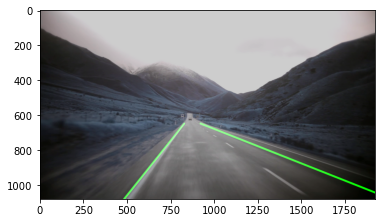

In [133]:
# show lanes detected in a frame
print('Lanes detected in frame')
plt.imshow(lane_detected_frames[50])